### Models X2Z | created 05/07/2022 | Models X2 for Maximum Projections

In [18]:
# General
import os
import sys
import pickle
import random
import string
import numpy as np
import pandas as pd
from datetime import date
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import __version__ as sk__version__

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__,
      "\nsklearn", sk__version__)

# Random Forest
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

python 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)] 
numpy 1.22.3 
pandas 1.4.2 
plotnine 0.8.0 
statsmodels 0.13.2 
sklearn 1.1.1


#### Functions

In [19]:
def opera_to_df(input, n_skip = 9):
    # Import Tab separated opera file
    raw_df = pd.read_csv(input, sep = '\t', skiprows = n_skip)       # Read file (txt or csv) and skip header
    #raw_df = raw_df.dropna(axis = 'Column')                    # Remove non-value columns
    return raw_df 

def filter_frame(df, col_idx):
    df_out = df[df['Column'] == col_idx]    # Select Column
    return df_out

In [20]:
def attach_trc(df, path_annotations):
    ls_trc = []

    with open(path_annotations) as f:
        for line in f:
            ls_trc.append(int(line))
    df['trc'] = ls_trc

def get_rfc_model(df, features, prediction, estimators, depth_max):
    y = df[prediction]
    X = df[features]

    c = RandomForestClassifier(n_estimators = estimators, max_depth = depth_max)
    m_rfc = c.fit(X,y)

    p = m_rfc.predict(X)

    print(classification_report(y,p))
    ConfusionMatrixDisplay.from_predictions(y, p)

    return m_rfc

def store_rfc_model(model, path, name):
    # Identifier
    date_raw = date.today()
    d1 = date_raw.strftime("%d%m%y")

    identifier = d1 + "_" + name
    folderpath = os.path.join(path, identifier).replace("\\","/")
    os.mkdir(folderpath)

    descriptor =    str(model.feature_names_in_) + \
                    str(model.feature_importances_) + "\n" + \
                    "Features: " + str(model.n_features_) + "\n" + \
                    "Max Depth: " + str(model.max_depth)

    # Write Descriptor
    with open(folderpath + '/readme.txt', 'w') as f:
        f.write(descriptor)

    # Write Model
    pickle.dump(model, open(folderpath + f'/{identifier}.rfc', "wb"))

def getModel(input, rc, in_out):
    # 1) Obtain proper cuts
    df_clc = opera_to_df(in_out[0] + '/' + input)
    
    if len(rc) > 1:
        clc_pos = df_clc[df_clc['Row'] == rc[0]]
        clc_pos = df_clc[df_clc['Column'] == rc[1]]
    else:
        clc_pos = df_clc[df_clc['Column'] == rc[0]]

    # 2) Obtain Annotation Data
    attach_trc(clc_pos, in_out[0] + '/cep.txt')

    prediction = ['trc']
    features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

    m_rfc = get_rfc_model(clc_pos, features, prediction, estimators = 10, depth_max = 5)
    return m_rfc

### 1) Model Generation

In [21]:
ar_0206 = opera_to_df('data/0206_assay_X/input_data/Objects_Population - coloc AR.txt')
ar_0206_wt_8 = filter_frame(ar_0206, 8)
ar_0206_wt_8.to_csv('data/0206_assay_X/output_data/ar_wt_8_full.csv')

C:\Users\Student\AppData\Local\Temp\ipykernel_8320\2095996707.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Student\AppData\Local\Temp\ipykernel_8320\2095996707.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        17

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123



c:\Users\Student\Desktop\LocalEnvs\localenv\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.


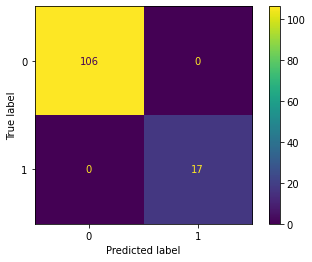

In [24]:
in_out = ['data/0206_assay_X/input_data', 'data/0206_assay_X/output_data']
path = 'Objects_Population - coloc AR.txt'
model = getModel(path, [8], in_out)

store_rfc_model(model, in_out[1], 'z_prime')

### 2) Model Prediction on 1606 WT | WELL 4

In [25]:
features = ['coloc AR - Spot Contrast', 'coloc AR - Spot Area [px²]', 'coloc AR - Relative Spot  Intensity', 'coloc AR - Corrected Spot  Intensity', 'coloc AR - Spot To Region Intensity']

In [29]:
# LOAD model
model = pickle.load(open('data/0206_assay_X/output_data/060722_z_prime/060722_z_prime.rfc', 'rb'))

# LOAD DATA
ar_coloc_1606 = opera_to_df('data/1606_assay_X/input_data/Objects_Population - coloc AR.txt')
ar_wt_pos_1606_4 = ar_coloc_1606[ar_coloc_1606['Column'] == 4]
print(f'Initial: {len(ar_wt_pos_1606_4)}')

X = ar_wt_pos_1606_4[features]

trc_wt = model.predict(X)
ar_wt_pos_1606_4['trc'] = trc_wt

ar_wt_pos_1606_4_view = ar_wt_pos_1606_4[ar_wt_pos_1606_4['trc'] == 1]
print(f'Final: {len(ar_wt_pos_1606_4_view)}')
ar_wt_pos_1606_4_view.to_csv('data/1606_assay_X/output_data/ar_wt_04_view.csv')

Initial: 257
Final: 19


C:\Users\Student\AppData\Local\Temp\ipykernel_8320\3658470154.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
